**Practice: Neural Networks with One Hidden Layer: Noisy XOR**

Objective: Create a neural network model with multiple neurons to model a simple function.

<h2>Table of Contents</h2>
<p>In this lab, you will see how many neurons it takes to classify noisy XOR data with one hidden layer neural network.</p>

<ul>
    <li><a href="#Model">Neural Network Module and Training Function</a></li>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#One">One Neuron</a></li>
    <li><a href="#Two">Two Neurons</a></li>
    <li><a href="#Three">Three Neurons</a></li>
</ul>


**Libraries**

In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
import numpy as np
import torch
import torch.nn as nn
#To use activation functions
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#Create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader

Use the following function to plot the data:

In [3]:
def plot_decision_regions_2class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    x = data_set.x.numpy()
    y = data_set.y.numpy()
    h=0.2
    #The code finds the smallest and largest values in each feature (column) of X and slightly expands the range by 0.1 on both ends. This ensures the plot covers all data points with some extra space for better visualization.
    x_min, x_max = x[:, 0].min()-0.1, x[:, 0].max()+0.1
    y_min, y_max = x[:, 1].min()-0.1, x[:, 0].max()+0.1
    xx, yy  = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    
    yhat = np.logical_not((model(XX)[:, 0]>0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(x[y[:, 0]==0, 0], x[y[:, 0]==0, 1], 'o', label='y=0')
    plt.plot(x[y[:, 0]==1, 0], x[y[:, 0]==1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

Use the following function to calculate accuracy:

In [4]:
def accuracy(model, data_set):
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0]>0.5).numpy())

**Neural Network Module and Training Function**

Defining Neural Network module or class:

In [5]:
#Defining the class net with one hidden layer
class Net(nn.Module):
    #Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        #D_in, size of the first input layer
        #H, out put of first layer, input of second layer(size of hidden layer)
        #D_out, output size of the second layer
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        
    #Prediction
    def forward(self,x):
        #Puting x through first layer and then sigmoid function
        x = torch.sigmoid(self.linear1(x))
        #again, put result of first layer 
        x = torch.sigmoid(self.linear2(x))
        return x
        

Defining functions to train the model:

In [6]:
def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    cost = []
    Accuracy = []
    #Number of time we train on the entire dataset
    for epoch in range(epochs):
        #total loss over epoch
        total=0
        #For batch in train loader
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            total += loss.item()
            
        Accuracy.append(accuracy(model, data_set))
        cost.append(total)
        
    #Cost vs epochs graph
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total_loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    #Accuracy vs Epoch graph
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(Accuracy, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()
    
    plt.show()
    return cost    

**Creating Data**

Dataset class:

In [7]:
#Definr the class XOR_Data

class XOR_Data(Dataset):
    #Constrocter
    #N_s is the size of the dataset
    def __init__ (self, N_s = 100):
        self.x = torch.zeros((N_s, 2)) #2 Dimensional array for features
        self.y = torch.zeros((N_s, 1)) #1 Dimensional array for class
        for i in range(N_s//4):
            #Create data centered arround (0,0) of class 0
            self.x[i, :] = torch.Tensor([0.0,0.0])
            self.y[i: 0] = torch.Tensor([0.0])
            
            #Create data centered around (0,1) for class 1
            self.x[i+N_s//4,:] = torch.Tensor([0.0,1.0])
            self.y[i+N_s//4,0] = torch.Tensor([1.0])
            
            #Create data centered around (1,0) of class 1
            self.x[i+N_s//2,:] = torch.Tensor([1.0,0.0])
            self.y[i+N_s//2,0] = torch.Tensor([1.0])
                   
            #Create data centered around (1,1) of class 0
            self.x[i+3*N_s//4, :] = torch.Tensor([1.0,1.0])
            self.y[i+3*N_s//4, 0]= torch.Tensor([0.0])
            
            #Add some noise to the x values to make them different
            self.x = self.x+0.01*torch.randn((N_s, 2))
        self.len = N_s
        
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.len
    
    def plot_stuff(self):
        plt.plot(self.x[self.y[:,0]==0, 0].numpy(), self.x[self.y[:,0]==0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:,0]==1, 0].numpy(), self.x[self.y[:,0]==0, 1].numpy(), 'ro', label="y=1")
        plt.legend()
    
    

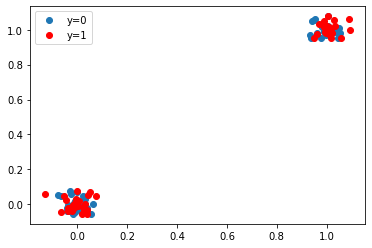

In [8]:
#Dataset object
data_set =XOR_Data()
data_set.plot_stuff()

**One Neuron**

Creating a neural network 'model' with one neuron in the hidden layer.

In [9]:
model = Net(2,1,1)
print(model)

Net(
  (linear1): Linear(in_features=2, out_features=1, bias=True)
  (linear2): Linear(in_features=1, out_features=1, bias=True)
)


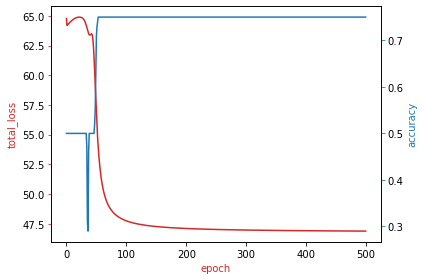

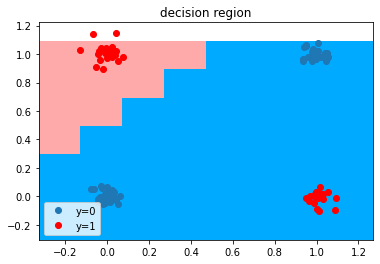

In [10]:
#Train the model

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
loss12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
#Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)

**Three Neurons**

In [11]:
model = Net(2,3,1)
print(model)

Net(
  (linear1): Linear(in_features=2, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=1, bias=True)
)


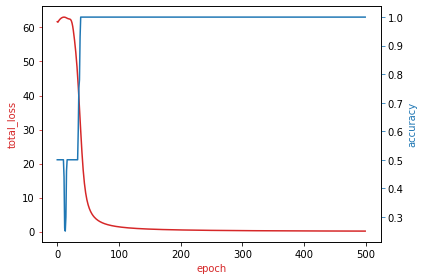

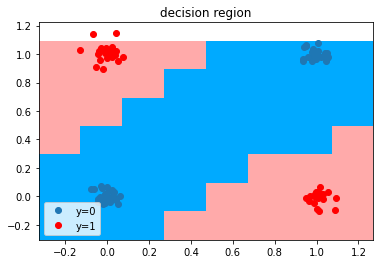

In [12]:
#Train the model

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
loss12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
#Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)

In [13]:
model = Net(2,4,1)
print(model)

Net(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


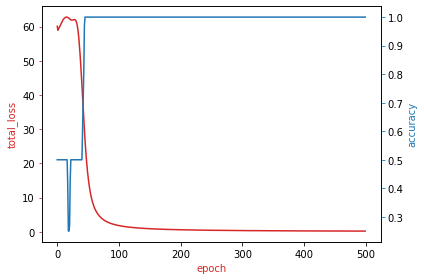

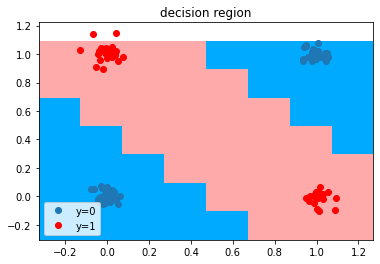

In [14]:
#Train the model

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
loss12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
#Plot the data with decision boundaries
plot_decision_regions_2class(model, data_set)